# India twitter trends analysis 

*  trends related SSR 

In [1]:
import pandas as pd
import glob
import datetime
import numpy as np
import math
import re
from decimal import Decimal
import plotly.express as px
import plotly.graph_objects as go

In [7]:
## millify - Humanize number package
def remove_exponent(d):
    """Remove exponent."""
    return d.quantize(Decimal(1)) if d == d.to_integral() else d.normalize()


def millify(n, precision=0, drop_nulls=True, prefixes=[]):
    """Humanize number."""
    millnames = ['', 'k', 'M', 'B', 'T', 'P', 'E', 'Z', 'Y']
    if prefixes:
        millnames = ['']
        millnames.extend(prefixes)
    n = float(n)
    millidx = max(0, min(len(millnames) - 1,
                         int(math.floor(0 if n == 0 else math.log10(abs(n)) / 3))))
    result = '{:.{precision}f}'.format(n / 10**(3 * millidx), precision=precision)
    if drop_nulls:
        result = remove_exponent(Decimal(result))
    return '{0}{dx}'.format(result, dx=millnames[millidx])


def prettify(amount, separator=','):
    """Separate with predefined separator."""
    orig = str(amount)
    new = re.sub("^(-?\d+)(\d{3})", "\g<1>{0}\g<2>".format(separator), str(amount))
    if orig == new:
        return new
    else:
        return prettify(new)
    
def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return " ".join([m.group(0) for m in matches])
camel_case_split("VikramJoshi")

'Vikram Joshi'

In [3]:
list_of_files = glob.glob("../data/*")
file_df=pd.DataFrame(list_of_files,columns=["filename"])

In [4]:
# datetime feature
file_df["datetime"]=file_df["filename"].apply(lambda x:datetime.datetime.strptime(x.split("_")[1][:-4],"%d%m%Y%H%M"))
file_df["month"]=file_df["datetime"].dt.month
file_df["date"]=file_df["datetime"].dt.date
file_df["year"]=file_df["datetime"].dt.year
file_df["hour"]=file_df["datetime"].dt.hour
file_df["dayofweek"]=file_df["datetime"].dt.dayofweek
file_df["day_name"]=file_df["datetime"].dt.day_name()
file_df["weekday"]=file_df["day_name"].isin(["Saturday","Sunday"])

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
file_df['session'] = pd.cut(file_df['hour'], bins=b, labels=l, include_lowest=True)

In [5]:
file_df["session"].value_counts()

Noon             283
Early Morning    283
Night            281
Late Night         3
Eve                2
Morning            2
Name: session, dtype: int64

In [6]:
# selecting noon session
file_df=file_df.sort_values(by=["datetime"]).reset_index()
Noon_df=file_df[file_df["session"]=="Noon"]

In [8]:
all_trends_df=pd.DataFrame()
for file in Noon_df["filename"].values:
    adf=pd.read_csv(file)
    adf["time_created"]=datetime.datetime.strptime(file.split("_")[1][:-4],"%d%m%Y%H%M")
    adf=adf[adf["location"]=="India"]
    all_trends_df=all_trends_df.append(adf,ignore_index=True)

In [9]:
all_trends_df["name_clean"]=all_trends_df["name"].apply(lambda x:camel_case_split(x.replace("#","")))
all_trends_df["name_clean"]=all_trends_df["name_clean"].apply(lambda x:x.lower())

In [10]:
all_trends_df.head()

Unnamed: 0                  name  \
0           0          #BabyPenguin   
1           1  #KurtaPajamaTomorrow   
2           2      #AskSushantSinha   
3           3        #twitterhacked   
4           4        #WorldSnakeDay   

                                                 url  promoted_content  \
0         http://twitter.com/search?q=%23BabyPenguin               NaN   
1  http://twitter.com/search?q=%23KurtaPajamaTomo...               NaN   
2     http://twitter.com/search?q=%23AskSushantSinha               NaN   
3       http://twitter.com/search?q=%23twitterhacked               NaN   
4       http://twitter.com/search?q=%23WorldSnakeDay               NaN   

                    query  tweet_volume location country  \
0          %23BabyPenguin       15206.0    India      IN   
1  %23KurtaPajamaTomorrow      344425.0    India      IN   
2      %23AskSushantSinha           NaN    India      IN   
3        %23twitterhacked       50523.0    India      IN   
4        %23WorldSnakeDay           NaN    India      IN   

                  as_of            created_at        time_created  \
0  2020-07-16T08:09:24Z  2020-07-16T08:07:33Z 2020-07-16 13:39:00   
1  2020-07-16T08:09:24Z  2020-07-16T08:07:33Z 2020-07-16 13:39:00   
2  2020-07-16T08:09:24Z  2020-07-16T08:07:33Z 2020-07-16 13:39:00   
3  2020-07-16T08:09:24Z  2020-07-16T08:07:33Z 2020-07-16 13:39:00   
4  2020-07-16T08:09:24Z  2020-07-16T08:07:33Z 2020-07-16 13:39:00   

              name_clean  
0           baby penguin  
1  kurta pajama tomorrow  
2      ask sushant sinha  
3          twitterhacked  
4        world snake day

In [11]:
ssr_df=all_trends_df[(all_trends_df["name_clean"].str.contains('ssr|rhea|sushant',case=False, regex=True))& 
              ~(all_trends_df["name_clean"].str.contains('sinha',case=False, regex=True))]

In [12]:
ssr_df["tweet_volume_i"]=ssr_df["tweet_volume"].interpolate().copy()

<ipython-input-12-3a7640be21bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ssr_df["tweet_volume_i"]=ssr_df["tweet_volume"].interpolate().copy()


In [13]:
ssr_df[["time_created","tweet_volume","name"]].head()

time_created  tweet_volume                          name
209 2020-07-21 13:39:00      103165.0              #SushantTruthNow
387 2020-07-25 13:39:00       11599.0          #ArrestCulpritsOfSSR
520 2020-07-29 13:40:00       62985.0  #JusticeforSushantSingRajput
607 2020-07-31 13:40:00       36141.0  #SushantSinghRajputDeathCase
635 2020-08-01 13:40:00       34336.0        #UddhavResignOrCBI4SSR

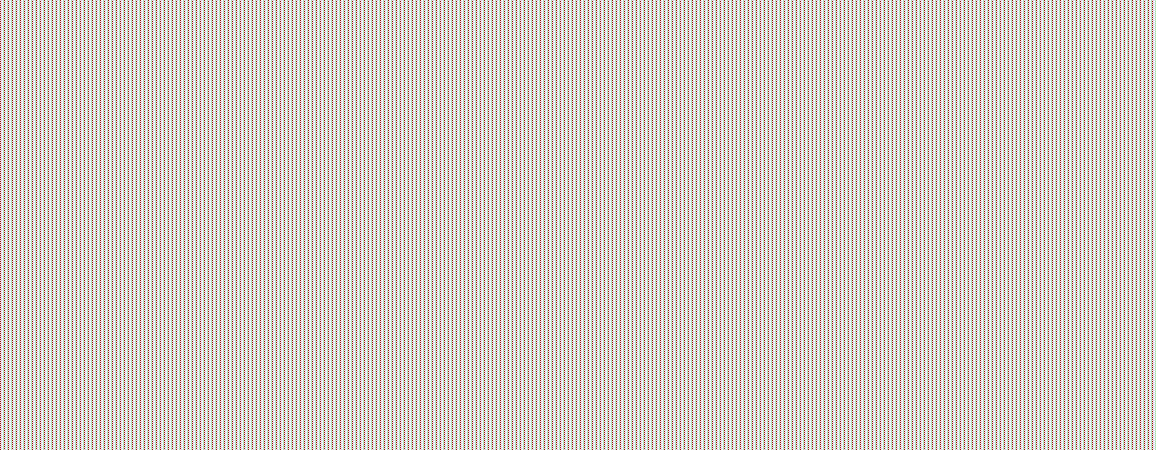

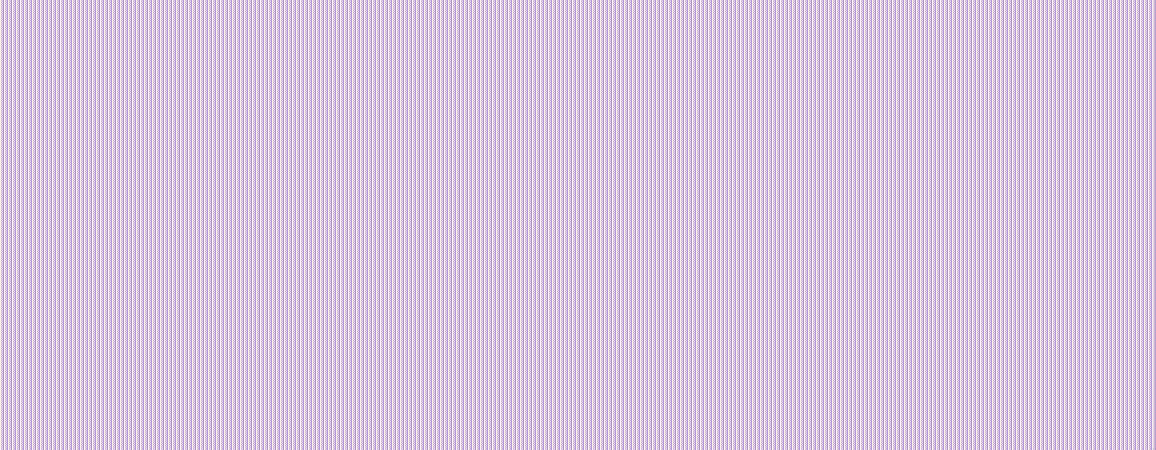

In [17]:
fig = px.area(ssr_df, x='time_created', y="tweet_volume_i",log_y=True,hover_data=["name"])
fig.data[0].visible=True
fig.update_xaxes(title="Time")
fig.update_yaxes(title="Tweet volume")

# Animation
init=1
fig.update(frames=[
    go.Frame(
        data=[
            go.Scatter(x=ssr_df.time_created[:k], y=ssr_df.tweet_volume_i[:k],visible=True,)],
            layout=go.Layout(title_text=f"Tweet volume :{millify(int(ssr_df.tweet_volume_i[:k].values[-1]))}   Date : {ssr_df.time_created.dt.date[:k].values[-1]}   Hashtag : {ssr_df.name[:k].values[-1]}")
    )
    for k in range(init, len(ssr_df)+1)])


# Buttons
fig.update_layout(
    updatemenus=[
        dict(type="buttons",
            buttons=list([
                dict(label="Play",
                    method="animate",
                    args=[None, {"frame": {"duration": 300}}]),
                dict(label="Pause",
                    method="animate",
                    args=[[None], {"frame": {"duration": 0, "redraw": False},
                          "mode": "immediate",
                          "transition": {"duration": 0}}])

            ]),x=1.1,y=1.0,pad= {'r': 10, 't': 87},
                     showactive= False,yanchor= "top",xanchor= "right",

            
        )])

fig.show()